In [51]:
# activation for openMP by setting the number of threads
import os
os.environ["OMP_NUM_THREADS"] = "8"  # number of threads
os.environ['MKL_NUM_THREADS'] = '4' # set number of MKL threads to run in parallel

from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
import numpy as np
from scipy.sparse.linalg import eigsh  # Sparse eigenvalue solver

import matplotlib.pyplot as plt


In [52]:
# Parameters
n_x = 2  # lattice size in x 
n_y = 2  # lattice size in y
J = 1.0  # coupling constant
chi = 1.0 # anisotropy
num_eigenvalues = 3 # number of eigenvalues that should be calculated (starting from the ground state)

L = n_x * n_y  # total number of spins
hz = 0.0
hy = 0.0


# Create the lattice couplings

In [53]:
# Site index mapping with periodic boundary conditions
def site(x, y):
    return (x % n_x) + n_x * (y % n_y)

# Generate all nearest-neighbor bonds without double-counting
J_ij = []
seen_bonds = set()  # use set to avoid douple counting

for x in range(n_x):
    for y in range(n_y):
        i = site(x, y)
        
        # periodic boundary conditions
        right = site(x+1, y)  # neighbor reight
        up = site(x, y+1)     # upper neighbor
        
        bond_right = tuple(sorted((i, right)))  # sort the indices
        bond_up = tuple(sorted((i, up)))

        if bond_right not in seen_bonds:
            J_ij.append([J, i, right])
            seen_bonds.add(bond_right)

        if bond_up not in seen_bonds:
            J_ij.append([J, i, up])
            seen_bonds.add(bond_up)

print(J_ij)

# 4x4 lattice with PBC
# J_ij = [[1.0, 0, 1], [1.0, 0, 4], [1.0, 4, 5], [1.0, 4, 8], [1.0, 8, 9], [1.0, 8, 12], [1.0, 12, 13], [1.0, 12, 0], 
#     [1.0, 1, 2], [1.0, 1, 5], [1.0, 5, 6], [1.0, 5, 9], [1.0, 9, 10], [1.0, 9, 13], [1.0, 13, 14], [1.0, 13, 1], 
#     [1.0, 2, 3], [1.0, 2, 6], [1.0, 6, 7], [1.0, 6, 10], [1.0, 10, 11], [1.0, 10, 14], [1.0, 14, 15], [1.0, 14, 2], 
#     [1.0, 3, 0], [1.0, 3, 7], [1.0, 7, 4], [1.0, 7, 11], [1.0, 11, 8], [1.0, 11, 15], [1.0, 15, 12], [1.0, 15, 3]]



[[1.0, 0, 1], [1.0, 0, 2], [1.0, 2, 3], [1.0, 1, 3]]


# Building the Hamiltonoperator

In [54]:
# define the interaction matrices
J_zz = [[1.0/4.0 * j[0], j[1], j[2]] for j in J_ij]
J_pm = [[chi * 1.0/4.0 * 0.5 * j[0], j[1], j[2]] for j in J_ij] 

# add magnetic field 
hz = np.array([hz*(-1)**(i+j) for i in range(n_x) for j in range(n_y)])
#hz = np.array([hz for i in range(n_x) for j in range(n_y)])
hz = hz.reshape(n_x, n_y).T
hz = hz.reshape(-1)
h_z = [[hz[i], i] for i in range(L)]

# create full basis
basis = spin_basis_1d(L,pauli=1)   # complete basis set

# create the hamiltonian as a sparse matrix
static = [["zz", J_zz], ["+-", J_pm], ["-+", J_pm], ["z", h_z]]
H_sparse = hamiltonian(static, [], basis=basis, dtype=np.float64, check_symm=False, check_pcon=False, check_herm=True).tocsr()   # Hamiltonian als sparse Matrix erstellen
np.set_printoptions(threshold=1000,linewidth=1000)
print(H_sparse.toarray())
#print(H_sparse)

# Create a set off S_z operators for each lattice site for measurement
sz_ops = []
for i in range(L):
    sz_i = [[0.5, i]]
    sz_i = hamiltonian([["z", sz_i]], [], basis=basis, dtype=np.complex128, check_herm=False, check_pcon=False, check_symm=False)
    sz_ops.append(sz_i)

Hermiticity check passed!
[[ 1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.5  0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.5  0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.5  0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5  0.   0.5 -1.   0.   0.   0.   0.5  0.   0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5  0.   0.5  0.   0. ]
 [ 0.   0.   0.5  0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5  0.   0.5  0.   0.   0.  -1.   0.5  0.   0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.   0. 

In [55]:
# def Hamilton_h(h):
#     hz = np.array([h*(-1)**(i+j) for i in range(n_x) for j in range(n_y)])
#     #hz = np.array([hz for i in range(n_x) for j in range(n_y)])
#     hz = hz.reshape(n_x, n_y).T
#     hz = hz.reshape(-1)
#     h_z = [[hz[i], i] for i in range(L)]

#     # create full basis
#     basis = spin_basis_1d(L)   # complete basis set

#     # create the hamiltonian as a sparse matrix
#     static = [["zz", J_zz], ["+-", J_pm], ["-+", J_pm], ["z", h_z]]
#     H_sparse = hamiltonian(static, [], basis=basis, dtype=np.float64, check_symm=False, check_pcon=False, check_herm=False).tocsr()   # Hamiltonian als sparse Matrix erstellen
#     eigenvalues, eigenvectors = eigsh(H_sparse, k=2, which='SA', tol=1e-18)   # 'SA' -> smallest algebraic eigenvalue
#     return eigenvalues, eigenvectors

# hz_list = np.linspace(0.0, 1e-3, 100)
# eigenvalue_0_list = []
# eigenvalue_1_list = []
# for i, h_ in enumerate(hz_list):
#     x, y = Hamilton_h(h_)
#     eigenvalue_0_list.append(x[0])
#     eigenvalue_1_list.append(x[1])
print(H_sparse.toarray())


[[ 1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.5  0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.5  0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.5  0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5  0.   0.5 -1.   0.   0.   0.   0.5  0.   0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5  0.   0.5  0.   0. ]
 [ 0.   0.   0.5  0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5  0.   0.5  0.   0.   0.  -1.   0.5  0.   0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.   0.   0.5  0. ]
 [ 0

In [56]:
# #plt.plot(hz_list, eigenvalue_0_list, '.-r', label='Groundstate')
# #plt.plot(hz_list, eigenvalue_1_list, '.-r', label='1st excited state')
# plt.plot(hz_list, np.abs(np.array(eigenvalue_0_list) - np.array(eigenvalue_1_list)), '.-r', label='difference')
# plt.legend(loc='upper right')
# #plt.xlim(0, 0.0002)
# #plt.ylim(0.3460, 0.3461)
# plt.grid()
# plt.show()


# Diagonalisation

In [57]:
# Berechnung des niedrigsten Eigenwerts und des Grundzustands-Eigenvektors:
eigenvalues, eigenvectors = eigsh(H_sparse, k=num_eigenvalues, which='SA', tol=1e-15)   # 'SA' -> smallest algebraic eigenvalue

print('Energy eigenvalues: {}'.format(eigenvalues))

Energy eigenvalues: [-2. -1. -1.]


### Calculating coefficients for state representation in the binary basis

In [58]:
def invert_bits(state, L):
    return state ^ (2**L - 1)

def invert_bits_2(state, L):
    bitstring = bin(state)[2:].zfill(L)
    flipped_bitstring = ''.join('1' if b == '0' else '0' for b in bitstring)
    number = int(flipped_bitstring, 2)
    return number

# Mapping von QuSpin -> externer Binärindex (mit invertierter Bit-Konvention)
for k in range(num_eigenvalues):
    psi_full = np.zeros(2**L, dtype=complex)
    for i, state in enumerate(basis.states):
        #print(state)
        flipped_state = invert_bits_2(state, L)
        #flipped_state_2 = invert_bits_2(state, L)
        psi_full[flipped_state] = eigenvectors[i, k]

    #print(np.real(psi_full))

    psi_real_imag = np.column_stack((psi_full.real, psi_full.imag))

    # save
    np.savetxt("output/coefficients_state_{:d}.txt".format(k), psi_real_imag, fmt="%.18e", delimiter=" ", header="real imag")

# Calculating the $S_z$ expectation value

In [59]:
for k in range(num_eigenvalues):

    sz_expectation_values = np.zeros(L, dtype=np.float64)

    # Erwartungswerte berechnen
    for i, sz_i in enumerate(sz_ops):
        sz_expectation_values[i] = np.real(sz_i.expt_value(eigenvectors[:, k])) # expectation value in the ground state

    print("Expectationvalue of S_z in state {} with energy {:.8f}".format(k, eigenvalues[k]))
    print(sz_expectation_values.reshape(n_x, n_y))
    print(" ")

Expectationvalue of S_z in state 0 with energy -2.00000000
[[0. 0.]
 [0. 0.]]
 
Expectationvalue of S_z in state 1 with energy -1.00000000
[[-0.01391942 -0.01391942]
 [-0.01391942 -0.01391942]]
 
Expectationvalue of S_z in state 2 with energy -1.00000000
[[0.2259304 0.2259304]
 [0.2259304 0.2259304]]
 


In [60]:
raise SystemExit("Manueller Stopp")

SystemExit: Manueller Stopp

# Time Evolution

In [ ]:
from quspin.operators import exp_op

start, stop, N_t = 0.0, 15.0, 150

# Basis
basis = spin_basis_1d(L)

# Zeitabhängiger Koeffizient
def h_t(t, args):
    return 1.0

# Operator: sigma^x
h_y = [[hy, i] for i in range(L)]

# Hamiltonian with stationary magnetic field along y
static = [["zz", J_zz], ["+-", J_pm], ["-+", J_pm], ["y", h_y], ["z", h_z]]
H = hamiltonian(static, [], basis=basis, dtype=np.complex128)

# State at t=0
psi_t0 = eigenvectors[:, 0]

# Time evolution through time evolution Operator
U = exp_op(H, a=-1j, start=start, stop=stop, num=N_t, iterate=True)

psi_t = U.dot(psi_t0)  # create generator object to apply matrix exponential on the initial state

psi_t_list = []
for psi_i in psi_t:
    psi_t_list.append(psi_i)

psi_t_list = np.array(psi_t_list)
print(np.shape(psi_t_list))



Hermiticity check passed!
Symmetry checks passed!
(150, 65536)


# Calculate the expectation values for every timestep

In [ ]:
# create all possible states in the hilbert space
# states = basis.states  # binary representation of the states

# # initialize a list to store the expectationvalues
# sz_expectation_values_t = np.zeros((N_t, L))

# # iterate over all spins
# for t in range(N_t):
#     for i in range(L):
#         # iterate over all states
#         for state_index, state in enumerate(states):
#             spin_state = (state >> i) & 1  # extract the state of the i-th spin (0 or 1)
#             sz_value = 0.5 if spin_state == 1 else -0.5
            
#             # contribution to the expectationvalue of s_z
#             probability = psi_t_list[t, state_index]**2
#             sz_expectation_values_t[t, i] += np.real(probability * sz_value)


# Ergebnisarray: shape (100, 4)
sz_expect_t = np.zeros((len(psi_t_list), L), dtype=np.float64)

# Erwartungswerte berechnen
for t_idx, psi_t in enumerate(psi_t_list):
    for i, sz_i in enumerate(sz_ops):
        sz_expect_t[t_idx, i] = np.real(sz_i.expt_value(psi_t))

sz_expect_total_t = np.sum(sz_expect_t, axis=1)

# Ergebnis anzeigen
# print("Shape der Magnetisierungserwartungswerte:", sz_expect_t.shape)
# print(sz_expect_t)

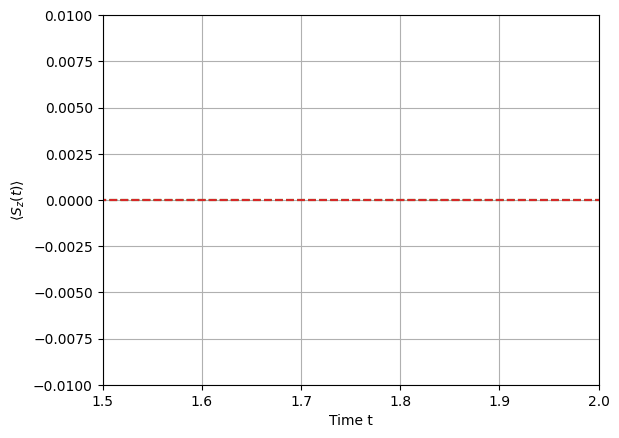

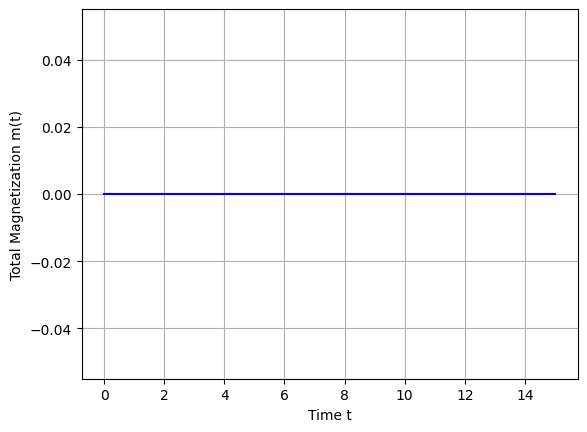

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.figure()
for i in range(L):
    #plt.plot(np.linspace(start, stop, N_t), sz_expectation_values_t[:, i], label='Spin %d' % (i))
    plt.plot(np.linspace(start, stop, N_t), sz_expect_t[:, i], '--')
plt.xlabel("Time t")
plt.ylabel(r"$\langle S_z(t) \rangle$")
#plt.legend(loc='upper right')
plt.grid(True)
plt.xlim(1.5, 2)
plt.ylim(-0.01, 0.01)
plt.show()

plt.plot(np.linspace(start, stop, N_t), sz_expect_total_t, '-b')
plt.grid()
plt.xlabel('Time t')
plt.ylabel('Total Magnetization m(t)')
plt.show()

23130